## This notebook tests experimental features that will likely change.

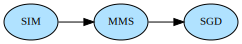

In [1]:
from lale.lib.rasl import SimpleImputer as SIM
from lale.lib.rasl import MinMaxScaler as MMS
from lale.lib.sklearn import SGDClassifier as SGD
from lale.lib.sklearn import RandomForestClassifier as RFC

def fresh_pipeline(final_est="sgd"):  #create new to guarantee fresh state after earlier fit/partial_fit, if any
    assert final_est in ["sgd", "rfc"]
    return (
        SIM(strategy="mean")
        >> MMS()
        >> (SGD(random_state=42) if final_est == "sgd" else RFC(random_state=42))
    )

fresh_pipeline().visualize()

In [2]:
from lale.lib.rasl import is_associative, is_incremental, PrioBatch, PrioStep, PrioResourceAware
from lale.lib.rasl import mockup_data_loader, fit_with_batches, cross_val_score
from sklearn.model_selection import KFold

assert is_associative(SIM)
assert is_associative(MMS)
assert is_incremental(SGD)
assert not is_incremental(RFC)

In [3]:
import lale.datasets.openml
import math
import pandas as pd
from lale.lib.lale import Project

(raw_train_X, train_y), (raw_test_X, test_y) = lale.datasets.openml.fetch("credit-g", "classification", preprocess=False)
project = Project(columns={"type": "number"}).fit(raw_train_X)
train_X, test_X = project.transform(raw_train_X), project.transform(raw_test_X)
unique_class_labels = list(train_y.unique())
print(f"unique_class_labels {unique_class_labels}")
train_data_space = train_X.memory_usage().sum() + train_y.memory_usage()
print(f"train_data_space {train_data_space}")
pd.set_option('display.max_rows', 6)
pd.concat([test_y, test_X], axis=1)

/home/hirzel/python3.7venv/lib/python3.7/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


unique_class_labels ['good', 'bad']
train_data_space 53600


,class,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
993,good,36.0,3959.0,4.0,3.0,30.0,1.0,1.0
859,good,9.0,3577.0,1.0,2.0,26.0,1.0,2.0
298,good,18.0,2515.0,3.0,4.0,43.0,1.0,1.0
...,...,...,...,...,...,...,...,...
503,bad,24.0,1216.0,4.0,4.0,38.0,2.0,2.0
263,good,12.0,2748.0,2.0,4.0,57.0,3.0,1.0
808,good,42.0,9283.0,1.0,2.0,55.0,1.0,1.0


### Example: no RASL

In [4]:
import lale.lib.rasl

accuracy_scorer = lale.lib.rasl.get_scorer("accuracy")

print(f"majority class {len(test_y[test_y == 'good']) / len(test_y):.3%}")
trained = fresh_pipeline().fit(train_X, train_y)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

majority class 70.909%
accuracy 70.909%


### Example: no batching, no cross-validation
- starting point
- behavior equivalent to sklearn
- purposely setting max_resident too low to demonstrate cache warnings

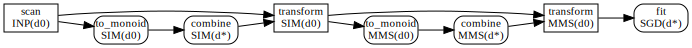

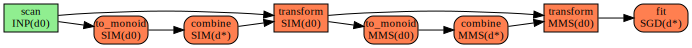

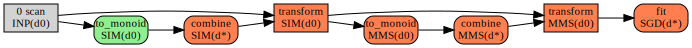

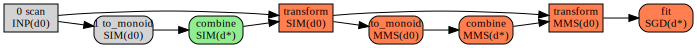

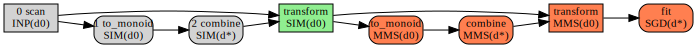

aborted spill of batch -1_d0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


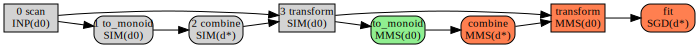

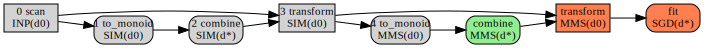

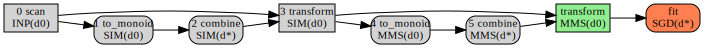

aborted spill of batch 0_d0_None
ensure_space() failed, amount_needed 53600, no_spill_space 53600, min_resident 107200, max_resident 53600


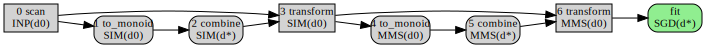

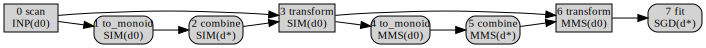

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 107200,
    "max_resident": 53600,
    "train_count": 5,
    "apply_count": 3,
    "metric_count": 0,
    "train_time": 0.06687712669372559,
    "apply_time": 0.06734538078308105,
    "metric_time": 0,
    "critical_count": 8,
    "critical_time": 0.13422250747680664,
}
accuracy 70.909%


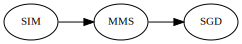

In [5]:
n_batches = 1
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
max_resident = 1 * math.ceil(train_data_space / n_batches)
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=3, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")
trained.visualize()

### Example: batching using associativity where possible, non-incremental final estimator

spill /tmp/tmpj2anobp5/X_-1_d2_None.pkl /tmp/tmpj2anobp5/y_-1_d2_None.pkl
spill /tmp/tmpj2anobp5/X_-1_d1_None.pkl /tmp/tmpj2anobp5/y_-1_d1_None.pkl
load /tmp/tmpj2anobp5/X_-1_d1_None.pkl /tmp/tmpj2anobp5/y_-1_d1_None.pkl
spill /tmp/tmpj2anobp5/X_0_d0_None.pkl /tmp/tmpj2anobp5/y_0_d0_None.pkl
load /tmp/tmpj2anobp5/X_-1_d2_None.pkl /tmp/tmpj2anobp5/y_-1_d2_None.pkl
load /tmp/tmpj2anobp5/X_0_d0_None.pkl /tmp/tmpj2anobp5/y_0_d0_None.pkl
spill /tmp/tmpj2anobp5/X_0_d2_None.pkl /tmp/tmpj2anobp5/y_0_d2_None.pkl
spill /tmp/tmpj2anobp5/X_0_d1_None.pkl /tmp/tmpj2anobp5/y_0_d1_None.pkl
load /tmp/tmpj2anobp5/X_0_d1_None.pkl /tmp/tmpj2anobp5/y_0_d1_None.pkl
spill /tmp/tmpj2anobp5/X_1_d0_None.pkl /tmp/tmpj2anobp5/y_1_d0_None.pkl
load /tmp/tmpj2anobp5/X_0_d2_None.pkl /tmp/tmpj2anobp5/y_0_d2_None.pkl
load /tmp/tmpj2anobp5/X_1_d0_None.pkl /tmp/tmpj2anobp5/y_1_d0_None.pkl


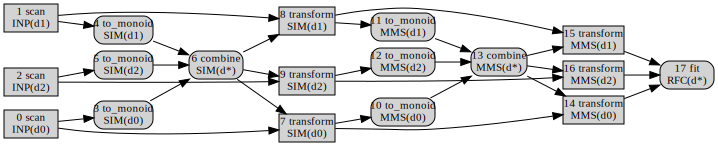

{
    "spill_count": 6,
    "load_count": 6,
    "spill_space": 107200,
    "load_space": 107200,
    "min_resident": 71520,
    "max_resident": 53601,
    "train_count": 9,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.6139931678771973,
    "apply_time": 0.20705676078796387,
    "metric_time": 0,
    "critical_count": 8,
    "critical_time": 0.6453526020050049,
}
accuracy 70.303%


In [6]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline("rfc"), batches, n_batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: pre-trained operator

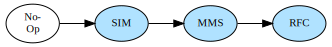

In [7]:
from lale.lib.lale import NoOp

pipeline = NoOp >> fresh_pipeline("rfc")
pipeline.visualize()

spill /tmp/tmp85d0dmrv/X_-1_d2_None.pkl /tmp/tmp85d0dmrv/y_-1_d2_None.pkl
spill /tmp/tmp85d0dmrv/X_-1_d1_None.pkl /tmp/tmp85d0dmrv/y_-1_d1_None.pkl
load /tmp/tmp85d0dmrv/X_-1_d1_None.pkl /tmp/tmp85d0dmrv/y_-1_d1_None.pkl
spill /tmp/tmp85d0dmrv/X_0_d0_None.pkl /tmp/tmp85d0dmrv/y_0_d0_None.pkl
load /tmp/tmp85d0dmrv/X_-1_d2_None.pkl /tmp/tmp85d0dmrv/y_-1_d2_None.pkl
load /tmp/tmp85d0dmrv/X_0_d0_None.pkl /tmp/tmp85d0dmrv/y_0_d0_None.pkl
spill /tmp/tmp85d0dmrv/X_0_d2_None.pkl /tmp/tmp85d0dmrv/y_0_d2_None.pkl
spill /tmp/tmp85d0dmrv/X_0_d1_None.pkl /tmp/tmp85d0dmrv/y_0_d1_None.pkl
load /tmp/tmp85d0dmrv/X_0_d1_None.pkl /tmp/tmp85d0dmrv/y_0_d1_None.pkl
spill /tmp/tmp85d0dmrv/X_1_d0_None.pkl /tmp/tmp85d0dmrv/y_1_d0_None.pkl
load /tmp/tmp85d0dmrv/X_0_d2_None.pkl /tmp/tmp85d0dmrv/y_0_d2_None.pkl
load /tmp/tmp85d0dmrv/X_1_d0_None.pkl /tmp/tmp85d0dmrv/y_1_d0_None.pkl
spill /tmp/tmp85d0dmrv/X_1_d2_None.pkl /tmp/tmp85d0dmrv/y_1_d2_None.pkl
spill /tmp/tmp85d0dmrv/X_1_d1_None.pkl /tmp/tmp85d0dmrv/y_1_d1

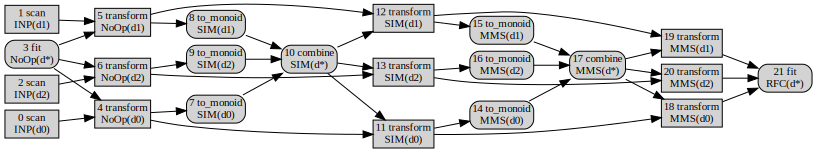

{
    "spill_count": 9,
    "load_count": 9,
    "spill_space": 160800,
    "load_space": 160800,
    "min_resident": 71520,
    "max_resident": 53601,
    "train_count": 10,
    "apply_count": 12,
    "metric_count": 0,
    "train_time": 0.48821091651916504,
    "apply_time": 0.27877116203308105,
    "metric_time": 0,
    "critical_count": 9,
    "critical_time": 0.5342898368835449,
}
accuracy 70.303%


In [8]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(pipeline, batches, n_batches, None, unique_class_labels,
                           max_resident, PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: batching using associativity where possible, partial_fit otherwise
- unlike our batching patent, which always used partial_fit
- behavior still equivalent to sklearn
- potential advantages: less resident data; parallelism
- below are three runs with three different scheduling priorities

spill /tmp/tmpvg2p4qx5/X_-1_d2_None.pkl /tmp/tmpvg2p4qx5/y_-1_d2_None.pkl
spill /tmp/tmpvg2p4qx5/X_-1_d1_None.pkl /tmp/tmpvg2p4qx5/y_-1_d1_None.pkl
load /tmp/tmpvg2p4qx5/X_-1_d1_None.pkl /tmp/tmpvg2p4qx5/y_-1_d1_None.pkl
spill /tmp/tmpvg2p4qx5/X_0_d0_None.pkl /tmp/tmpvg2p4qx5/y_0_d0_None.pkl
load /tmp/tmpvg2p4qx5/X_-1_d2_None.pkl /tmp/tmpvg2p4qx5/y_-1_d2_None.pkl
load /tmp/tmpvg2p4qx5/X_0_d0_None.pkl /tmp/tmpvg2p4qx5/y_0_d0_None.pkl
spill /tmp/tmpvg2p4qx5/X_0_d2_None.pkl /tmp/tmpvg2p4qx5/y_0_d2_None.pkl
spill /tmp/tmpvg2p4qx5/X_0_d1_None.pkl /tmp/tmpvg2p4qx5/y_0_d1_None.pkl
load /tmp/tmpvg2p4qx5/X_0_d1_None.pkl /tmp/tmpvg2p4qx5/y_0_d1_None.pkl
spill /tmp/tmpvg2p4qx5/X_1_d0_None.pkl /tmp/tmpvg2p4qx5/y_1_d0_None.pkl
load /tmp/tmpvg2p4qx5/X_0_d2_None.pkl /tmp/tmpvg2p4qx5/y_0_d2_None.pkl
load /tmp/tmpvg2p4qx5/X_1_d0_None.pkl /tmp/tmpvg2p4qx5/y_1_d0_None.pkl


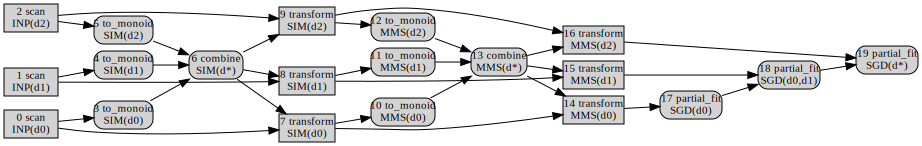

{
    "spill_count": 6,
    "load_count": 6,
    "spill_space": 107200,
    "load_space": 107200,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 11,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.11300444602966309,
    "apply_time": 0.17307353019714355,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.12063336372375488,
}
accuracy 62.424%


In [9]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels, max_resident,
                           PrioStep(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

spill /tmp/tmpfz_ldj9u/X_-1_d2_None.pkl /tmp/tmpfz_ldj9u/y_-1_d2_None.pkl
spill /tmp/tmpfz_ldj9u/X_-1_d1_None.pkl /tmp/tmpfz_ldj9u/y_-1_d1_None.pkl
load /tmp/tmpfz_ldj9u/X_-1_d1_None.pkl /tmp/tmpfz_ldj9u/y_-1_d1_None.pkl
spill /tmp/tmpfz_ldj9u/X_0_d0_None.pkl /tmp/tmpfz_ldj9u/y_0_d0_None.pkl
load /tmp/tmpfz_ldj9u/X_-1_d2_None.pkl /tmp/tmpfz_ldj9u/y_-1_d2_None.pkl
load /tmp/tmpfz_ldj9u/X_0_d0_None.pkl /tmp/tmpfz_ldj9u/y_0_d0_None.pkl
spill /tmp/tmpfz_ldj9u/X_0_d2_None.pkl /tmp/tmpfz_ldj9u/y_0_d2_None.pkl
spill /tmp/tmpfz_ldj9u/X_0_d1_None.pkl /tmp/tmpfz_ldj9u/y_0_d1_None.pkl
load /tmp/tmpfz_ldj9u/X_0_d1_None.pkl /tmp/tmpfz_ldj9u/y_0_d1_None.pkl
load /tmp/tmpfz_ldj9u/X_0_d2_None.pkl /tmp/tmpfz_ldj9u/y_0_d2_None.pkl


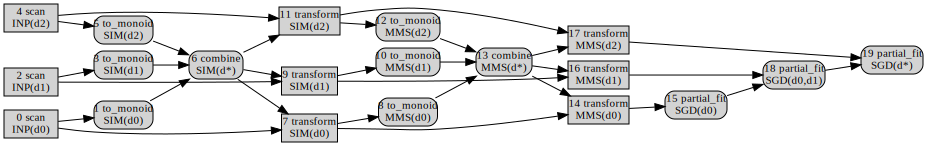

{
    "spill_count": 5,
    "load_count": 5,
    "spill_space": 89280,
    "load_space": 89280,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 11,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.09612298011779785,
    "apply_time": 0.16121792793273926,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.11896467208862305,
}
accuracy 62.424%


In [10]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels, max_resident,
                           PrioBatch(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

spill /tmp/tmp9jg2vmrr/X_-1_d2_None.pkl /tmp/tmp9jg2vmrr/y_-1_d2_None.pkl
spill /tmp/tmp9jg2vmrr/X_-1_d1_None.pkl /tmp/tmp9jg2vmrr/y_-1_d1_None.pkl
load /tmp/tmp9jg2vmrr/X_-1_d1_None.pkl /tmp/tmp9jg2vmrr/y_-1_d1_None.pkl
spill /tmp/tmp9jg2vmrr/X_0_d0_None.pkl /tmp/tmp9jg2vmrr/y_0_d0_None.pkl
load /tmp/tmp9jg2vmrr/X_-1_d2_None.pkl /tmp/tmp9jg2vmrr/y_-1_d2_None.pkl
load /tmp/tmp9jg2vmrr/X_0_d0_None.pkl /tmp/tmp9jg2vmrr/y_0_d0_None.pkl
spill /tmp/tmp9jg2vmrr/X_1_d1_None.pkl /tmp/tmp9jg2vmrr/y_1_d1_None.pkl
load /tmp/tmp9jg2vmrr/X_1_d1_None.pkl /tmp/tmp9jg2vmrr/y_1_d1_None.pkl


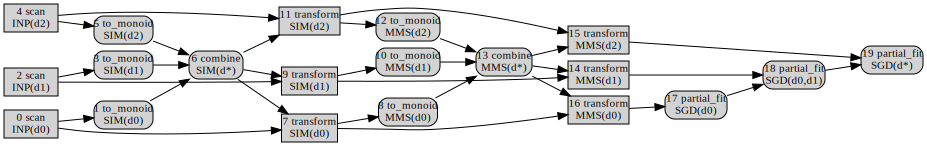

{
    "spill_count": 4,
    "load_count": 4,
    "spill_space": 71440,
    "load_space": 71440,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 11,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.12351632118225098,
    "apply_time": 0.13891363143920898,
    "metric_time": 0,
    "critical_count": 10,
    "critical_time": 0.14619040489196777,
}
accuracy 62.424%


In [11]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels, max_resident,
                           PrioResourceAware(), incremental=False, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: incremental computation, start using transformer before it has seen all data
- behavior not equivalent to sklearn, instead more similar to DL
- but may be "close enough" if operators are "convergent"
- advantage: need much less resident data
- amenable to early stopping, extracting a checkpoint

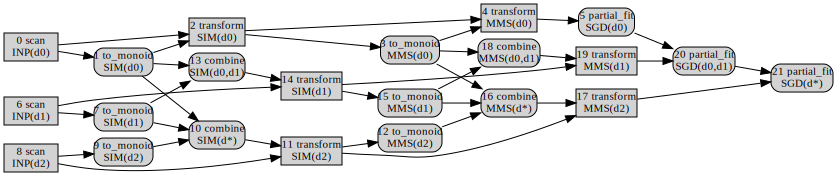

{
    "spill_count": 0,
    "load_count": 0,
    "spill_space": 0,
    "load_space": 0,
    "min_resident": 35840,
    "max_resident": 53601,
    "train_count": 13,
    "apply_count": 9,
    "metric_count": 0,
    "train_time": 0.09166145324707031,
    "apply_time": 0.0685880184173584,
    "metric_time": 0,
    "critical_count": 9,
    "critical_time": 0.07424068450927734,
}
accuracy 70.303%


In [12]:
n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, None, unique_class_labels,
                           max_resident, PrioBatch(), incremental=True, verbose=2, progress_callback=None)
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: learning curve during incremental fit_with_batches

spill /tmp/tmpmo6dq1jx/X_-1_d0_None.pkl /tmp/tmpmo6dq1jx/y_-1_d0_None.pkl
load /tmp/tmpmo6dq1jx/X_-1_d0_None.pkl /tmp/tmpmo6dq1jx/y_-1_d0_None.pkl
callback state 68.750%
spill /tmp/tmpmo6dq1jx/X_-1_d2_None.pkl /tmp/tmpmo6dq1jx/y_-1_d2_None.pkl
spill /tmp/tmpmo6dq1jx/X_-1_d1_None.pkl /tmp/tmpmo6dq1jx/y_-1_d1_None.pkl
load /tmp/tmpmo6dq1jx/X_-1_d1_None.pkl /tmp/tmpmo6dq1jx/y_-1_d1_None.pkl
callback state 68.750%, 68.161%
load /tmp/tmpmo6dq1jx/X_-1_d2_None.pkl /tmp/tmpmo6dq1jx/y_-1_d2_None.pkl
callback state 68.750%, 68.161%, 71.300%


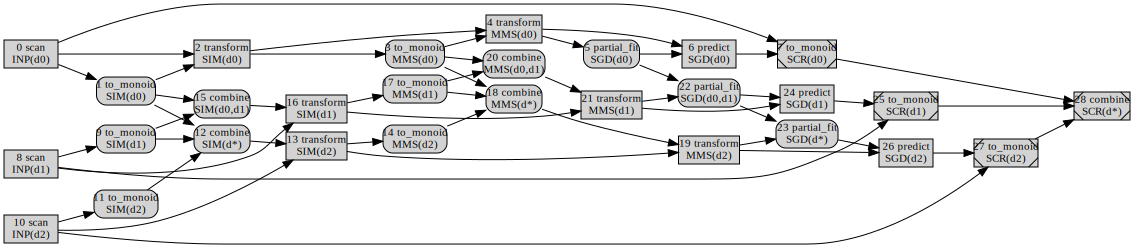

{
    "spill_count": 3,
    "load_count": 3,
    "spill_space": 53600,
    "load_space": 53600,
    "min_resident": 53760,
    "max_resident": 53601,
    "train_count": 13,
    "apply_count": 12,
    "metric_count": 4,
    "train_time": 0.07056903839111328,
    "apply_time": 0.10824823379516602,
    "metric_time": 0.05801033973693848,
    "critical_count": 12,
    "critical_time": 0.0962533950805664,
}
accuracy 70.303%


In [13]:
class DummyCallback:  # ideally, should create a dynamically updating plot in Jupyter
    def __init__(self):
        self.scores = []
    
    def __call__(self, score):
        self.scores.append(score)
        scores_s = ", ".join(f"{s:.3%}" for s in self.scores)
        print(f"callback state {scores_s}")

n_batches = 3
max_resident = 3 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
trained = fit_with_batches(fresh_pipeline(), batches, n_batches, accuracy_scorer, unique_class_labels,
                           max_resident, PrioBatch(), incremental=True, verbose=2, progress_callback=DummyCallback())
print(f"accuracy {accuracy_scorer(trained, test_X, test_y):.3%}")

### Example: cross-validation without batching, using same-fold data for training
- behavior equivalent to sklearn
- reuse of lifted coefficients limited to first operator
- disambiguate some tasks by `#~f`, where f is the left-out fold
- using associativity where possible, partial_fit otherwise

spill /tmp/tmpna9e7r_3/X_-1_d0_None.pkl /tmp/tmpna9e7r_3/y_-1_d0_None.pkl
spill /tmp/tmpna9e7r_3/X_-1_e0_None.pkl /tmp/tmpna9e7r_3/y_-1_e0_None.pkl
spill /tmp/tmpna9e7r_3/X_0_e0_d.pkl /tmp/tmpna9e7r_3/y_0_e0_d.pkl
spill /tmp/tmpna9e7r_3/X_-1_f0_None.pkl /tmp/tmpna9e7r_3/y_-1_f0_None.pkl
load /tmp/tmpna9e7r_3/X_0_e0_d.pkl /tmp/tmpna9e7r_3/y_0_e0_d.pkl
spill /tmp/tmpna9e7r_3/X_0_f0_e.pkl /tmp/tmpna9e7r_3/y_0_f0_e.pkl
load /tmp/tmpna9e7r_3/X_-1_d0_None.pkl /tmp/tmpna9e7r_3/y_-1_d0_None.pkl
spill /tmp/tmpna9e7r_3/X_0_f0_f.pkl /tmp/tmpna9e7r_3/y_0_f0_f.pkl
spill /tmp/tmpna9e7r_3/X_0_e0_e.pkl /tmp/tmpna9e7r_3/y_0_e0_e.pkl
spill /tmp/tmpna9e7r_3/X_-1_d0_None.pkl /tmp/tmpna9e7r_3/y_-1_d0_None.pkl
load /tmp/tmpna9e7r_3/X_0_e0_e.pkl /tmp/tmpna9e7r_3/y_0_e0_e.pkl
load /tmp/tmpna9e7r_3/X_0_f0_f.pkl /tmp/tmpna9e7r_3/y_0_f0_f.pkl
load /tmp/tmpna9e7r_3/X_0_f0_e.pkl /tmp/tmpna9e7r_3/y_0_f0_e.pkl
load /tmp/tmpna9e7r_3/X_-1_e0_None.pkl /tmp/tmpna9e7r_3/y_-1_e0_None.pkl
load /tmp/tmpna9e7r_3/X_-1_f0_None

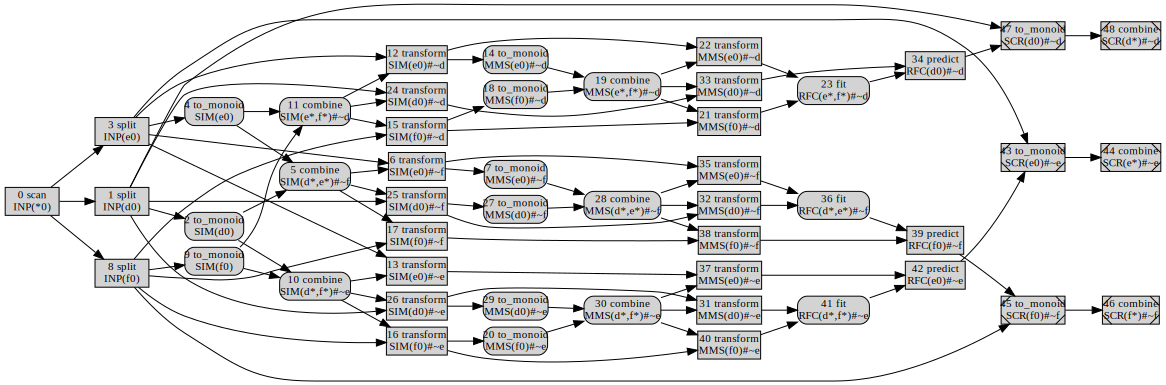

{
    "spill_count": 8,
    "load_count": 8,
    "spill_space": 142880,
    "load_space": 142880,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 18,
    "apply_count": 25,
    "metric_count": 6,
    "train_time": 0.913597822189331,
    "apply_time": 0.4587581157684326,
    "metric_time": 0.050141096115112305,
    "critical_count": 12,
    "critical_time": 0.41034364700317383,
}
accuracies 72.768%, 68.161%, 69.507%


In [14]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline("rfc"), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with batching, using same-fold data for training
- compared to cross-validation without batching, requires less resident memory

spill /tmp/tmp5_xcotwp/X_-1_*1_None.pkl /tmp/tmp5_xcotwp/y_-1_*1_None.pkl
spill /tmp/tmp5_xcotwp/X_-1_d0_None.pkl /tmp/tmp5_xcotwp/y_-1_d0_None.pkl
spill /tmp/tmp5_xcotwp/X_-1_e0_None.pkl /tmp/tmp5_xcotwp/y_-1_e0_None.pkl
load /tmp/tmp5_xcotwp/X_-1_*1_None.pkl /tmp/tmp5_xcotwp/y_-1_*1_None.pkl
spill /tmp/tmp5_xcotwp/X_-1_f0_None.pkl /tmp/tmp5_xcotwp/y_-1_f0_None.pkl
spill /tmp/tmp5_xcotwp/X_-1_d1_None.pkl /tmp/tmp5_xcotwp/y_-1_d1_None.pkl
spill /tmp/tmp5_xcotwp/X_0_e1_f.pkl /tmp/tmp5_xcotwp/y_0_e1_f.pkl
spill /tmp/tmp5_xcotwp/X_-1_e1_None.pkl /tmp/tmp5_xcotwp/y_-1_e1_None.pkl
spill /tmp/tmp5_xcotwp/X_-1_f1_None.pkl /tmp/tmp5_xcotwp/y_-1_f1_None.pkl
load /tmp/tmp5_xcotwp/X_-1_f0_None.pkl /tmp/tmp5_xcotwp/y_-1_f0_None.pkl
spill /tmp/tmp5_xcotwp/X_0_f1_d.pkl /tmp/tmp5_xcotwp/y_0_f1_d.pkl
spill /tmp/tmp5_xcotwp/X_0_f1_e.pkl /tmp/tmp5_xcotwp/y_0_f1_e.pkl
spill /tmp/tmp5_xcotwp/X_0_f1_f.pkl /tmp/tmp5_xcotwp/y_0_f1_f.pkl
spill /tmp/tmp5_xcotwp/X_-1_f0_None.pkl /tmp/tmp5_xcotwp/y_-1_f0_None.pk

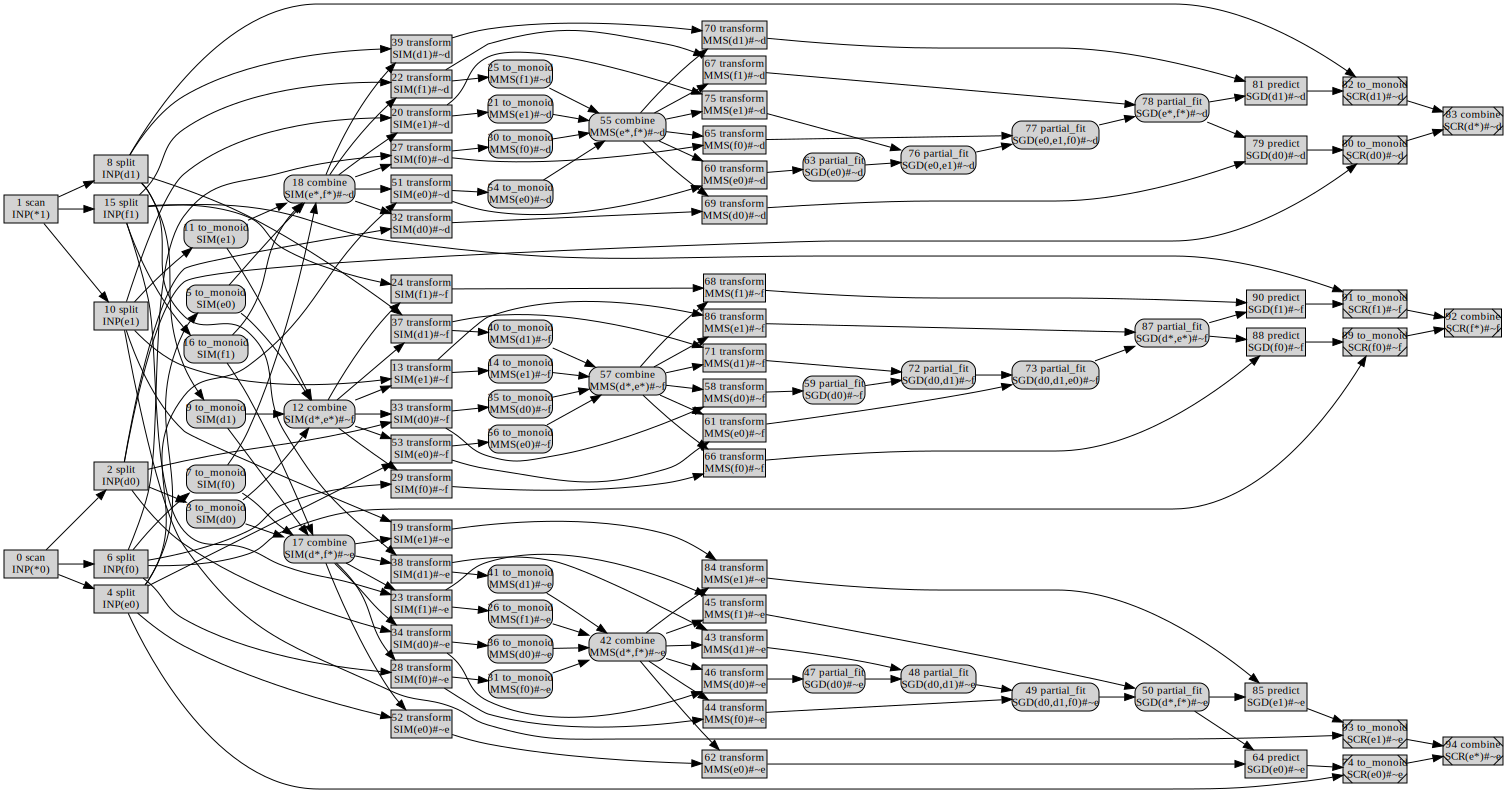

{
    "spill_count": 29,
    "load_count": 29,
    "spill_space": 276640,
    "load_space": 276640,
    "min_resident": 53600,
    "max_resident": 53600,
    "train_count": 36,
    "apply_count": 50,
    "metric_count": 9,
    "train_time": 0.26583337783813477,
    "apply_time": 0.8699836730957031,
    "metric_time": 0.06608223915100098,
    "critical_count": 15,
    "critical_time": 0.18655920028686523,
}
accuracies 68.304%, 75.000%, 66.667%


In [15]:
n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=True, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

### Example: cross-validation with out-of-fold samples
- not sklearn compatible
- might generalize better by following best practices for stacking ensembles
- depends on transformers being convergent
- fewer tasks overall than for cross-validation with in-fold samples

spill /tmp/tmpjl9sc6t8/X_-1_d0_None.pkl /tmp/tmpjl9sc6t8/y_-1_d0_None.pkl
load /tmp/tmpjl9sc6t8/X_-1_d0_None.pkl /tmp/tmpjl9sc6t8/y_-1_d0_None.pkl
spill /tmp/tmpjl9sc6t8/X_-1_f0_None.pkl /tmp/tmpjl9sc6t8/y_-1_f0_None.pkl
spill /tmp/tmpjl9sc6t8/X_-1_e0_None.pkl /tmp/tmpjl9sc6t8/y_-1_e0_None.pkl
load /tmp/tmpjl9sc6t8/X_-1_e0_None.pkl /tmp/tmpjl9sc6t8/y_-1_e0_None.pkl
load /tmp/tmpjl9sc6t8/X_-1_f0_None.pkl /tmp/tmpjl9sc6t8/y_-1_f0_None.pkl


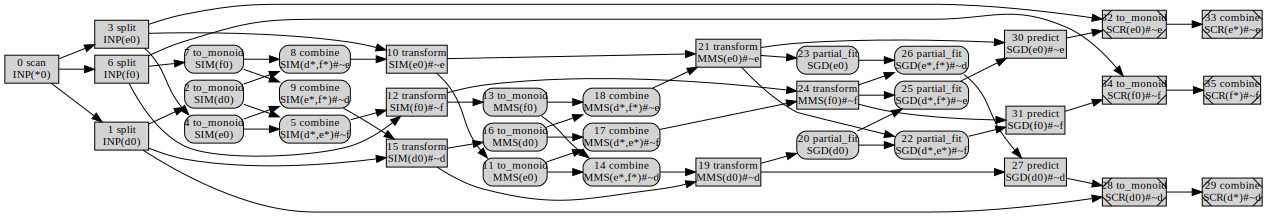

{
    "spill_count": 3,
    "load_count": 3,
    "spill_space": 53600,
    "load_space": 53600,
    "min_resident": 107200,
    "max_resident": 107200,
    "train_count": 17,
    "apply_count": 13,
    "metric_count": 6,
    "train_time": 0.11250114440917969,
    "apply_time": 0.133467435836792,
    "metric_time": 0.04506254196166992,
    "critical_count": 13,
    "critical_time": 0.13016057014465332,
}
accuracies 69.196%, 67.713%, 71.749%


In [16]:
n_batches = 1
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))

spill /tmp/tmpfcrb_bec/X_-1_*1_None.pkl /tmp/tmpfcrb_bec/y_-1_*1_None.pkl
spill /tmp/tmpfcrb_bec/X_-1_d0_None.pkl /tmp/tmpfcrb_bec/y_-1_d0_None.pkl
spill /tmp/tmpfcrb_bec/X_-1_e0_None.pkl /tmp/tmpfcrb_bec/y_-1_e0_None.pkl
load /tmp/tmpfcrb_bec/X_-1_*1_None.pkl /tmp/tmpfcrb_bec/y_-1_*1_None.pkl
spill /tmp/tmpfcrb_bec/X_-1_f0_None.pkl /tmp/tmpfcrb_bec/y_-1_f0_None.pkl
spill /tmp/tmpfcrb_bec/X_-1_d1_None.pkl /tmp/tmpfcrb_bec/y_-1_d1_None.pkl
load /tmp/tmpfcrb_bec/X_-1_f0_None.pkl /tmp/tmpfcrb_bec/y_-1_f0_None.pkl
spill /tmp/tmpfcrb_bec/X_-1_f1_None.pkl /tmp/tmpfcrb_bec/y_-1_f1_None.pkl
load /tmp/tmpfcrb_bec/X_-1_d0_None.pkl /tmp/tmpfcrb_bec/y_-1_d0_None.pkl
spill /tmp/tmpfcrb_bec/X_0_f1_f.pkl /tmp/tmpfcrb_bec/y_0_f1_f.pkl
spill /tmp/tmpfcrb_bec/X_-1_f0_None.pkl /tmp/tmpfcrb_bec/y_-1_f0_None.pkl
spill /tmp/tmpfcrb_bec/X_0_f0_f.pkl /tmp/tmpfcrb_bec/y_0_f0_f.pkl
load /tmp/tmpfcrb_bec/X_-1_d1_None.pkl /tmp/tmpfcrb_bec/y_-1_d1_None.pkl
spill /tmp/tmpfcrb_bec/X_-1_e1_None.pkl /tmp/tmpfcrb_bec/y

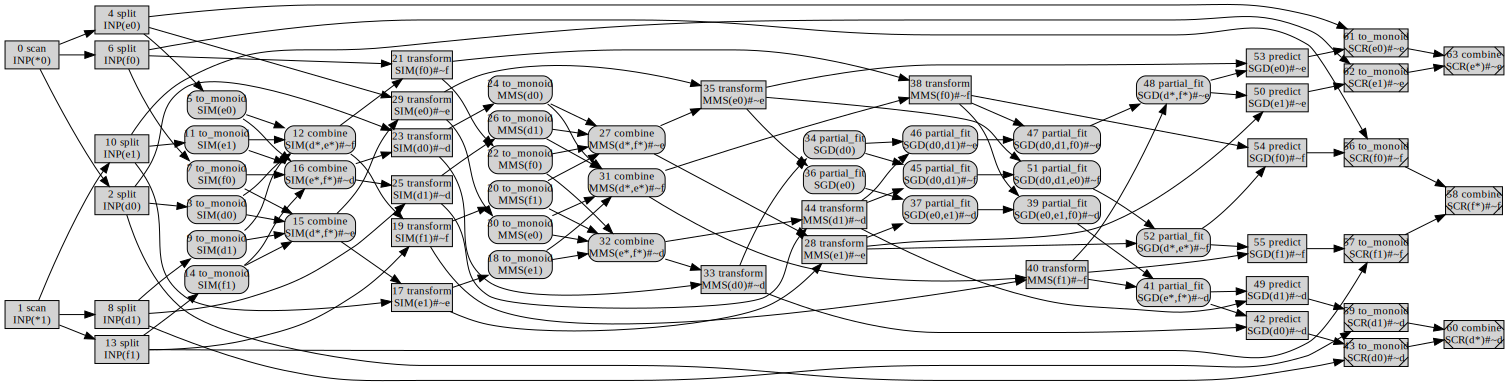

{
    "spill_count": 14,
    "load_count": 14,
    "spill_space": 142880,
    "load_space": 142880,
    "min_resident": 53600,
    "max_resident": 53600,
    "train_count": 29,
    "apply_count": 26,
    "metric_count": 9,
    "train_time": 0.2971036434173584,
    "apply_time": 0.4619462490081787,
    "metric_time": 0.06239628791809082,
    "critical_count": 15,
    "critical_time": 0.19255304336547852,
}
accuracies 67.411%, 68.750%, 65.766%


In [17]:
n_batches = 2
max_resident = 2 * math.ceil(train_data_space / n_batches)
batches = mockup_data_loader(train_X, train_y, n_batches, "pandas")
scores = cross_val_score(fresh_pipeline(), batches, n_batches, accuracy_scorer, KFold(3),
                         unique_class_labels, max_resident, PrioResourceAware(), same_fold=False, verbose=2)
print("accuracies " + ", ".join(f"{score:.3%}" for score in scores))